In [17]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from sklearn.model_selection import KFold

BATCH_SIZE = 32
IMG_SIZE   = (150, 150)
train_dir = 'dataset/training'
test_dir = 'dataset/test'

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                           shuffle=True,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE)

test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           shuffle=True,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE)


Found 2000 files belonging to 2 classes.
Found 400 files belonging to 2 classes.


In [18]:
# Configuring dataset for performance
# Use buffered prefetching to load images from disk without having I/O become blocking.

AUTOTUNE = tf.data.AUTOTUNE

train_dataset  = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset   = test_dataset.prefetch(buffer_size=AUTOTUNE)

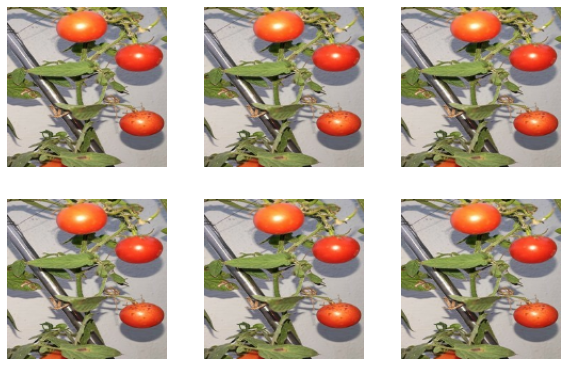

In [19]:
# Augmenting the data

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
])

# Validate augmented images
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first = image[0]
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        augmented_img = data_augmentation(tf.expand_dims(first, 0))
        plt.imshow(augmented_img[0]/ 255)
        plt.axis('off')

In [20]:
# Using MobileNetV2 as base model.
# NOTE: MobileNet expects pixel values in [-1, 1], so the pictures need to be rescaled.

# Using the Preprocess method in the model to rescale images
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


# Alternative method for rescaling is the tf.keras.layers.Rescaling.
# rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)


# Creating the model
# By specifying the include_top=False argument, 
# you load a network that doesn't include the classification layers at the top, 
# which is ideal for feature extraction.

IMG_SHAPE  = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 1s 0us/step


In [21]:
# The feature extractor converts each 160x160x3 image into a 5x5x1280 block of features.

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

# Freezing the convolutional base and using it as a feature extractor 
base_model.trainable = False

# When setting layer.trainable = FALSE, the BatchNormalization layer will run in inference mode, and will not
# update its mean and variance statistics
# When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, 
# you should keep the BatchNormalization layers in inference mode by passing training = False when calling 
# the base model. Otherwise, the updates applied to the non-trainable weights 
# will destroy what the model has learned.

# Checking the base model architecture
base_model.summary()

(32, 5, 5, 1280)
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_5[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0        

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 19, 19, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 19, 19, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 19, 19, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 19, 19, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [22]:
# Adding a classification head
# To generate predicitions from the block of features, average over the spatial 5x5 spatial locations, using 
# a GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

# Apply a Dense layer to convert these features into a single prediction per image.
# No need for activation function, due to the prediction being treated as a logit.

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

# Building the model by chaining together the layers that were just created.
inputs = tf.keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


# Compiling the model
# Currently there are two classes, so using the BinaryCrossentropy loss with from_logits=true since the model
# provides a linear output.

lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr,),
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=['accuracy'])

model.summary()

(32, 1280)
(32, 1)
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 150, 150, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 150, 150, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                        

In [23]:
train_images = np.concatenate(list(train_dataset.map(lambda x, y: x)))
train_labels = np.concatenate(list(train_dataset.map(lambda x, y: y)))
                              
kfold = KFold(n_splits=9, shuffle=True)

for train, test in kfold.split(train_images, train_labels):
    # Testing without validation set
    history = model.fit(train_images[train],
                        train_labels[train],
                        batch_size=BATCH_SIZE,
                        epochs=2)

    loss, accuracy = model.evaluate(train_images[test], train_labels[test], verbose=0)

Epoch 1/2
56/56 [==============================] - 16s 253ms/step - loss: 0.8949 - accuracy: 0.4862
Epoch 2/2
56/56 [==============================] - 15s 264ms/step - loss: 0.8373 - accuracy: 0.4986
Epoch 1/2
56/56 [==============================] - 15s 268ms/step - loss: 0.8140 - accuracy: 0.5070
Epoch 2/2
56/56 [==============================] - 15s 271ms/step - loss: 0.7942 - accuracy: 0.5138
Epoch 1/2
56/56 [==============================] - 15s 268ms/step - loss: 0.8203 - accuracy: 0.5006
Epoch 2/2
56/56 [==============================] - 15s 273ms/step - loss: 0.8059 - accuracy: 0.5146
Epoch 1/2
56/56 [==============================] - 15s 265ms/step - loss: 0.7771 - accuracy: 0.5084
Epoch 2/2
30/56 [===============>..............] - ETA: 6s - loss: 0.7923 - accuracy: 0.5000

KeyboardInterrupt: 

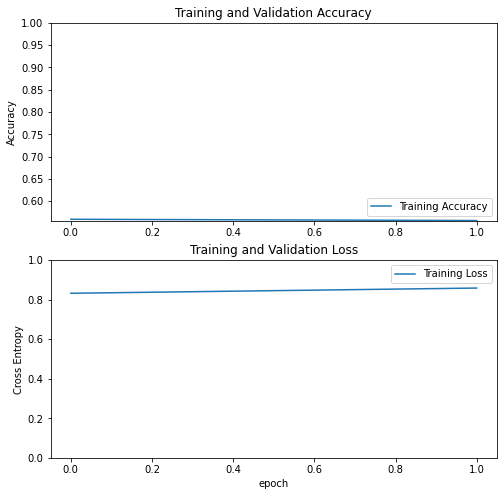

In [15]:
# Learning cures

acc = history.history['accuracy']

loss = history.history['loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.legend(loc="lower right")
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.legend(loc="upper right")
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [16]:
print("Loss: ", loss)
print("Accuracy: ", accuracy)

Loss:  [0.8323245644569397, 0.8587212562561035]
Accuracy:  0.5900900959968567
